In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow import Variable
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

In [2]:
def prob_k_gaussian(x, mu_list, sigma_list, amplitude_list):
    amplitude_list = amplitude_list.reshape(1, -1)
    norm_amplitude = tf.exp(amplitude_list)/tf.reduce_sum(tf.exp(amplitude_list))
    sigma_list = sigma_list.reshape(1, -1)
    mu_list = mu_list.reshape(1, -1)
    x = x.reshape(-1, 1)
    return np.sum(norm_amplitude/(np.sqrt(2*np.pi)*sigma_list)*tf.exp(- 0.5*(x-mu_list)**2/sigma_list**2), axis=1)
    
class t_k_gaussian(Model):
    def __init__(self, k, input_shape, 
                 mu0_list, sigma0_list, amplitude0_list,
                 train_mu=True, train_sigma=True, train_amplitude=False,
                name='model', **kwargs):
        super().__init__(name=name, **kwargs)
        if len(mu0_list)!=k or len(sigma0_list)!=k or len(amplitude0_list)!=k:
            raise Exception('list length does not coincide with k!')
        self.mu        = Variable(initial_value=np.array(mu0_list).reshape((1, -1)),        dtype="float32", trainable=train_mu,        name='mu')
        self.sigma     = Variable(initial_value=np.array(sigma0_list).reshape((1, -1)),     dtype="float32", trainable=train_sigma,     name='sigma')
        self.amplitude = Variable(initial_value=np.array(amplitude0_list).reshape((1, -1))/np.sum(amplitude0_list), dtype="float32", trainable=train_amplitude, name='amplitude')
        
        self.build(input_shape)
        
    def call(self, x):
        norm_amplitude = tf.exp(self.amplitude)/tf.reduce_sum(tf.exp(self.amplitude))
        return 2*tf.math.log(tf.reduce_sum(norm_amplitude/self.sigma*tf.exp(0.5*x**2 - 0.5*(x-self.mu)**2/self.sigma**2), axis=1))

def loss(true, pred):
    return -1*tf.reduce_sum(pred)

def p_val_empirical(t_obs, t_ref):
    num= np.sum(t_ref>t_obs)
    if num: return num*1./len(t_ref)
    else: return 1./len(t_ref)

In [3]:
seed = 1234
np.random.seed(seed)
N = 50
mu0, std0 = 0, 1
mu1, std1 = 0, 1.2
mu2, std2 = 0.83, 0.5
reference = norm.rvs(loc=mu0, scale=std0, size=N)
data1 = norm.rvs(loc=mu1, scale=std1, size=N)
data2 = np.append(norm.rvs(loc=mu2, scale=std2, size=int(N/2)), norm.rvs(loc=-1*mu2, scale=std2, size=int(N/2)))

# t(k=1)

### null distribution

In [378]:
k=1
t_ref1 = []
for _ in range(100):
    mu0_list=np.linspace(-0.5*k, 0.5*k, k)
    amplitude0_list=np.ones(k)*1./k
    sigma0_list=np.ones(k)
    model= t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list)
    #opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
    model.compile(loss=loss,  optimizer='adam')
    ####
    data = norm.rvs(loc=mu0, scale=std0, size=N)
    for epoch in range(999):
        model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    pred = model.predict(data.reshape(-1, 1))
    t_ref1.append(-1*loss(np.ones_like(data), pred).numpy())
    


2/2 [==============================] - 0s 2ms/step


### alternative data 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 3
Trainable params: 2
Non-trainable params: 1
_________________________________________________________________


2023-05-23 12:16:17.555456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
2/2 [==============================] - 0s 2ms/step


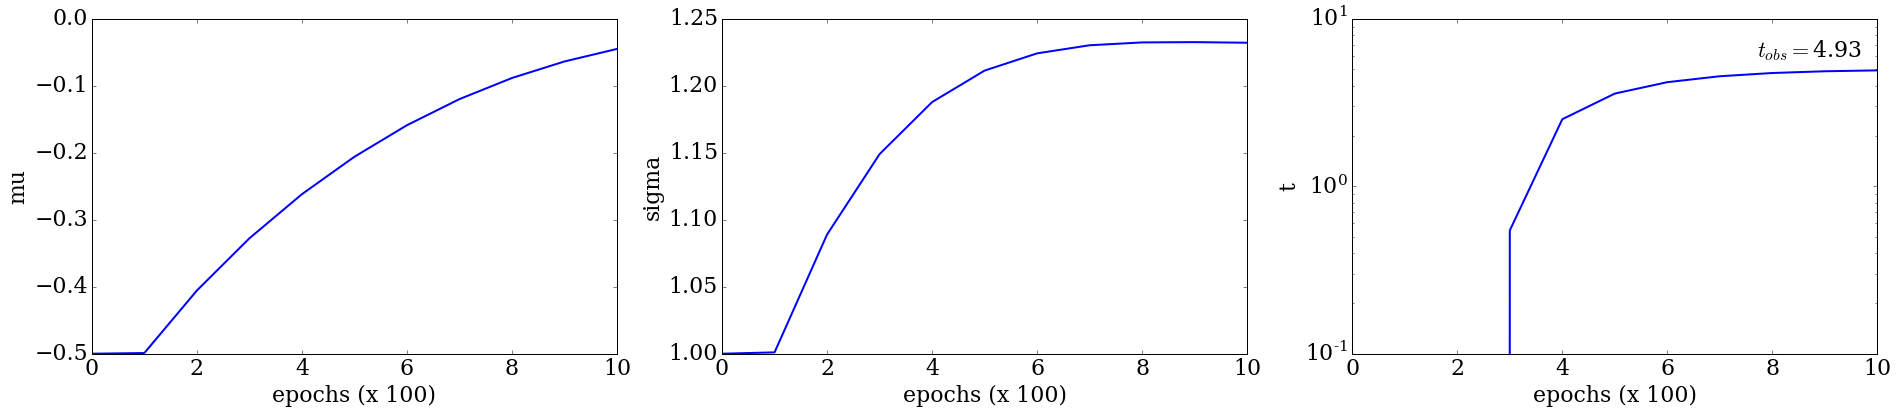

In [4]:
k=1
mu0_list=np.linspace(-0.5*k, 0.5*k, k)
amplitude0_list=np.ones(k)*1./k
sigma0_list=np.ones(k)
model=t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list)
print(model.summary())
opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
model.compile(loss=loss,  optimizer='adam')
####
data = data1
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 3, figsize=(32, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 3, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.subplot(1, 3, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 3, 3)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.yscale('log')
t_obs = -1*hist['loss'][-1]
plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

In [5]:
loc1_data1, scale1_data1, amplitude1_data1 = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
print(loc1_data1, scale1_data1, amplitude1_data1)

[-0.04484846] [1.23219931] [1.]


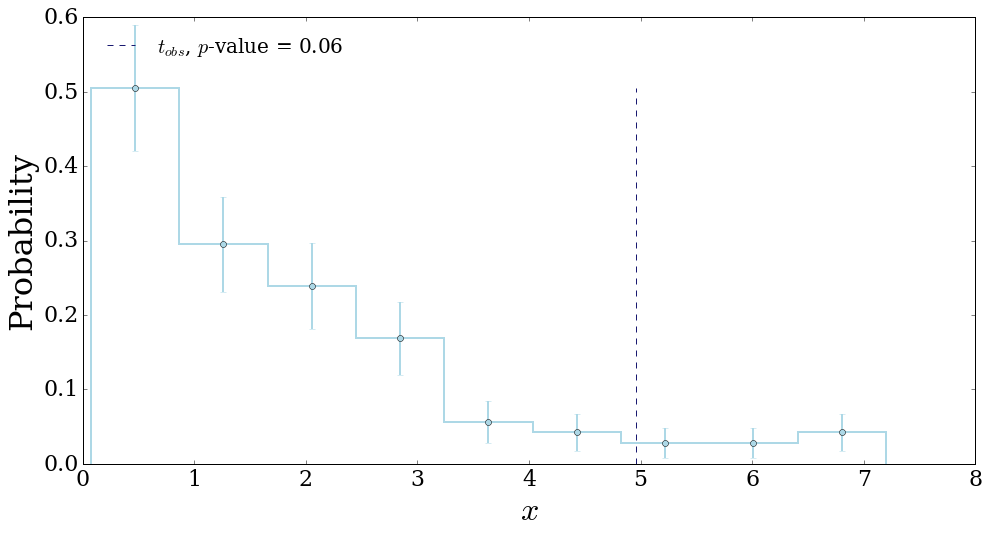

In [416]:
sample1 = np.array(t_ref1)
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 10
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, t_ref1), 2))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

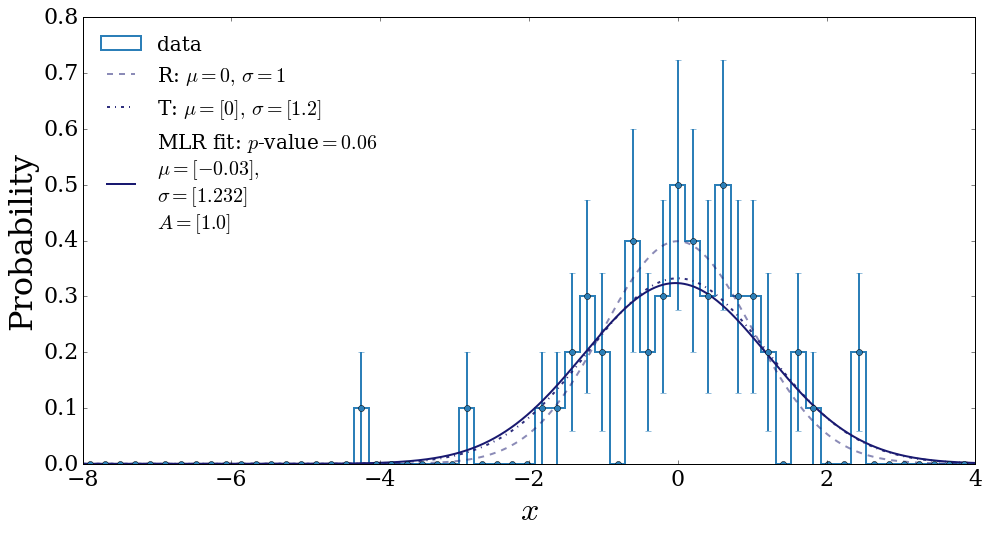

In [418]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 2000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu1]), np.array([std1]), np.array([1.])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=2, alpha=0.9, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if i==4: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, t_ref1), 3)))+'\n'+label)

font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

### alternative data 2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 3
Trainable params: 2
Non-trainable params: 1
_________________________________________________________________
None
2/2 [==============================] - 0s 2ms/step


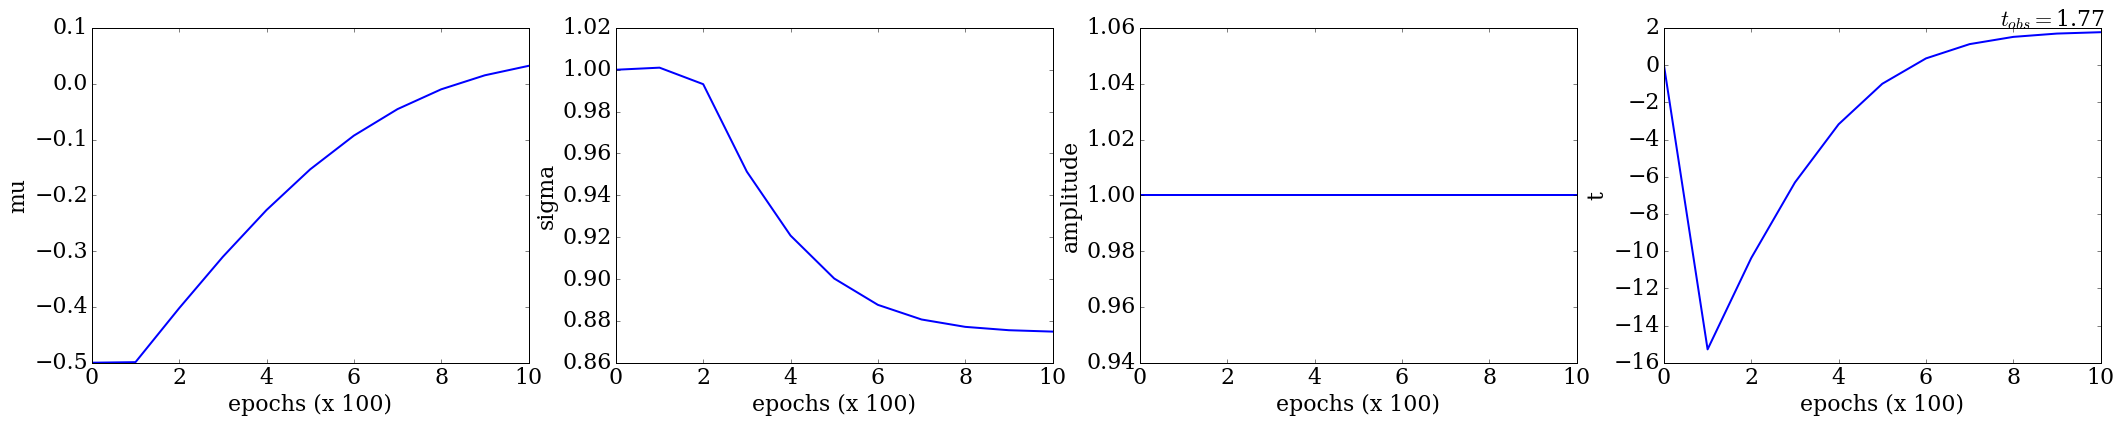

In [6]:
k=1
mu0_list=np.linspace(-0.5*k, 0.5*k, k)
amplitude0_list=np.ones(k)*1./k
sigma0_list=np.ones(k)
model=t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list)
print(model.summary())
opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
model.compile(loss=loss,  optimizer='adam')
####
data = data2
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

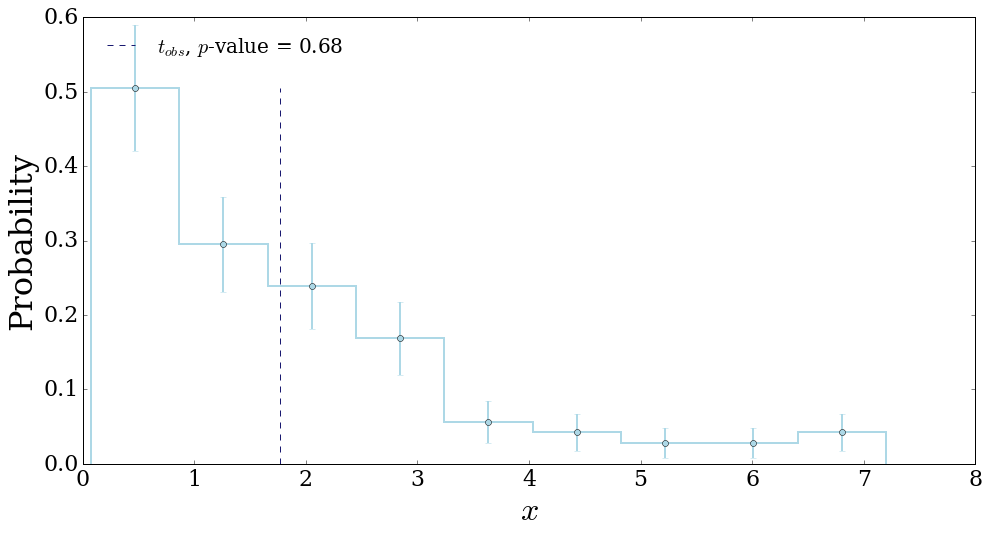

In [380]:
sample1 = np.array(t_ref1)
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 10
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, t_ref), 2))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

In [7]:
loc1_data2, scale1_data2, amplitude1_data2 = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
print(loc1_data2, scale1_data2, amplitude1_data2)

[0.0319767] [0.87486446] [1.]


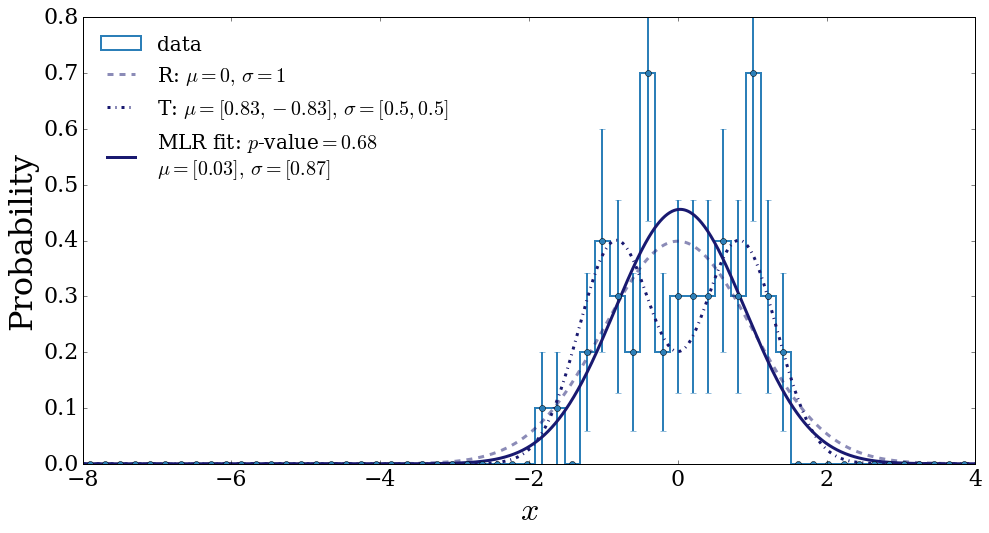

In [381]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)
x = np.linspace(-8, 8, 2000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=3, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu2, -mu2]), np.array([std2, std2]), np.array([0.5, 0.5])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=3,  ls='-.', label='T: '+label)

label = r'$\mu= %s,\,\sigma=%s$'%(np.around(hist['mu'][-1, :], 2), np.around(hist['sigma'][-1, :],2))
plt.plot(x, prob_k_gaussian(x, hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]), color='midnightblue', lw=3, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, t_ref), 2)))+'\n'+label)


font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

# t(k=2)

### null distribution

In [353]:
k=2
t_ref2 = []
for i in range(1000):
    mu0_list=np.linspace(-0.5, 0.5, k)
    amplitude0_list=np.ones(k)*1./k
    sigma0_list=np.ones(k)
    model= t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
    opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
    model.compile(loss=loss,  optimizer='adam')
    ####
    data = norm.rvs(loc=mu0, scale=std0, size=N)
    for epoch in range(1999):
        model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    pred = model.predict(data.reshape(-1, 1))
    t_ref2.append(-1*loss(np.ones_like(data), pred).numpy())
    print(i, t_ref2[-1])


2/2 [==============================] - 0s 2ms/step
0 3.7825980186462402
2/2 [==============================] - 0s 2ms/step
1 7.918985366821289
2/2 [==============================] - 0s 3ms/step
2 4.349102020263672
2/2 [==============================] - 0s 2ms/step
3 3.907726287841797
2/2 [==============================] - 0s 2ms/step
4 8.341238021850586
2/2 [==============================] - 0s 2ms/step
5 4.1819915771484375
2/2 [==============================] - 0s 2ms/step
6 10.16081714630127
2/2 [==============================] - 0s 2ms/step
7 4.0208001136779785
2/2 [==============================] - 0s 2ms/step
8 14.053020477294922
2/2 [==============================] - 0s 2ms/step
9 5.6233954429626465
2/2 [==============================] - 0s 2ms/step
10 2.7089359760284424
2/2 [==============================] - 0s 2ms/step
11 4.672075271606445
2/2 [==============================] - 0s 2ms/step
12 0.303842693567276
2/2 [==============================] - 0s 2ms/step
13 1.071083784103

2023-04-07 13:11:04.891683: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2023-04-07 13:11:05.268437: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step
16 2.41266131401062


2023-04-07 13:11:07.736819: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2023-04-07 13:11:07.751462: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step
17 3.413896083831787
2/2 [==============================] - 0s 2ms/step
18 6.502557754516602
2/2 [==============================] - 0s 2ms/step
19 2.5103485584259033
2/2 [==============================] - 0s 2ms/step
20 1.993545651435852
2/2 [==============================] - 0s 2ms/step
21 0.8735963702201843
2/2 [==============================] - 0s 2ms/step
22 2.7177469730377197
2/2 [==============================] - 0s 2ms/step
23 6.435882091522217
2/2 [==============================] - 0s 2ms/step
24 2.9733548164367676
2/2 [==============================] - 0s 2ms/step
25 1.7548474073410034
2/2 [==============================] - 0s 2ms/step
26 3.482745885848999
2/2 [==============================] - 0s 3ms/step
27 8.236501693725586
2/2 [==============================] - 0s 2ms/step
28 1.8157265186309814
2/2 [==============================] - 0s 2ms/step
29 1.7707016468048096
2/2 [==============================] - 0s 2ms/step
30 7.7

2/2 [==============================] - 0s 2ms/step
130 5.071040153503418
2/2 [==============================] - 0s 2ms/step
131 3.3616106510162354
2/2 [==============================] - 0s 2ms/step
132 7.704494476318359
2/2 [==============================] - 0s 2ms/step
133 4.257556915283203
2/2 [==============================] - 0s 2ms/step
134 8.064675331115723
2/2 [==============================] - 0s 2ms/step
135 0.31937626004219055
2/2 [==============================] - 0s 3ms/step
136 2.635211229324341
2/2 [==============================] - 0s 2ms/step
137 13.66178035736084
2/2 [==============================] - 0s 2ms/step
138 5.391800403594971
2/2 [==============================] - 0s 2ms/step
139 3.0235471725463867
2/2 [==============================] - 0s 2ms/step
140 3.202270030975342
2/2 [==============================] - 0s 2ms/step
141 0.41081809997558594
2/2 [==============================] - 0s 2ms/step
142 5.3573102951049805
2/2 [==============================] - 0s 2m

2/2 [==============================] - 0s 2ms/step
353 11.421242713928223
2/2 [==============================] - 0s 2ms/step
354 5.260507583618164
2/2 [==============================] - 0s 2ms/step
355 4.8056254386901855
2/2 [==============================] - 0s 2ms/step
356 4.234272480010986
2/2 [==============================] - 0s 2ms/step
357 1.3783167600631714
2/2 [==============================] - 0s 2ms/step
358 2.110764741897583
2/2 [==============================] - 0s 2ms/step
359 5.797801494598389
2/2 [==============================] - 0s 2ms/step
360 1.7637875080108643
2/2 [==============================] - 0s 2ms/step
361 9.980957984924316
2/2 [==============================] - 0s 2ms/step
362 4.456076622009277
2/2 [==============================] - 0s 2ms/step
363 5.449851989746094
2/2 [==============================] - 0s 2ms/step
364 8.490339279174805
2/2 [==============================] - 0s 2ms/step
365 4.877287864685059
2/2 [==============================] - 0s 3ms/s

2/2 [==============================] - 0s 2ms/step
465 10.605847358703613
2/2 [==============================] - 0s 2ms/step
466 3.4276955127716064
2/2 [==============================] - 0s 2ms/step
467 3.6180408000946045
2/2 [==============================] - 0s 2ms/step
468 4.707243919372559
2/2 [==============================] - 0s 2ms/step
469 3.0961391925811768
2/2 [==============================] - 0s 3ms/step
470 3.4750313758850098
2/2 [==============================] - 0s 2ms/step
471 3.06644344329834
2/2 [==============================] - 0s 2ms/step
472 10.581765174865723
2/2 [==============================] - 0s 2ms/step
473 8.62478256225586
2/2 [==============================] - 0s 2ms/step
474 5.816673278808594
2/2 [==============================] - 0s 2ms/step
475 9.337520599365234
2/2 [==============================] - 0s 2ms/step
476 8.092819213867188
2/2 [==============================] - 0s 2ms/step
477 1.4140853881835938
2/2 [==============================] - 0s 2ms/

KeyboardInterrupt: 

### alternative 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 2ms/step


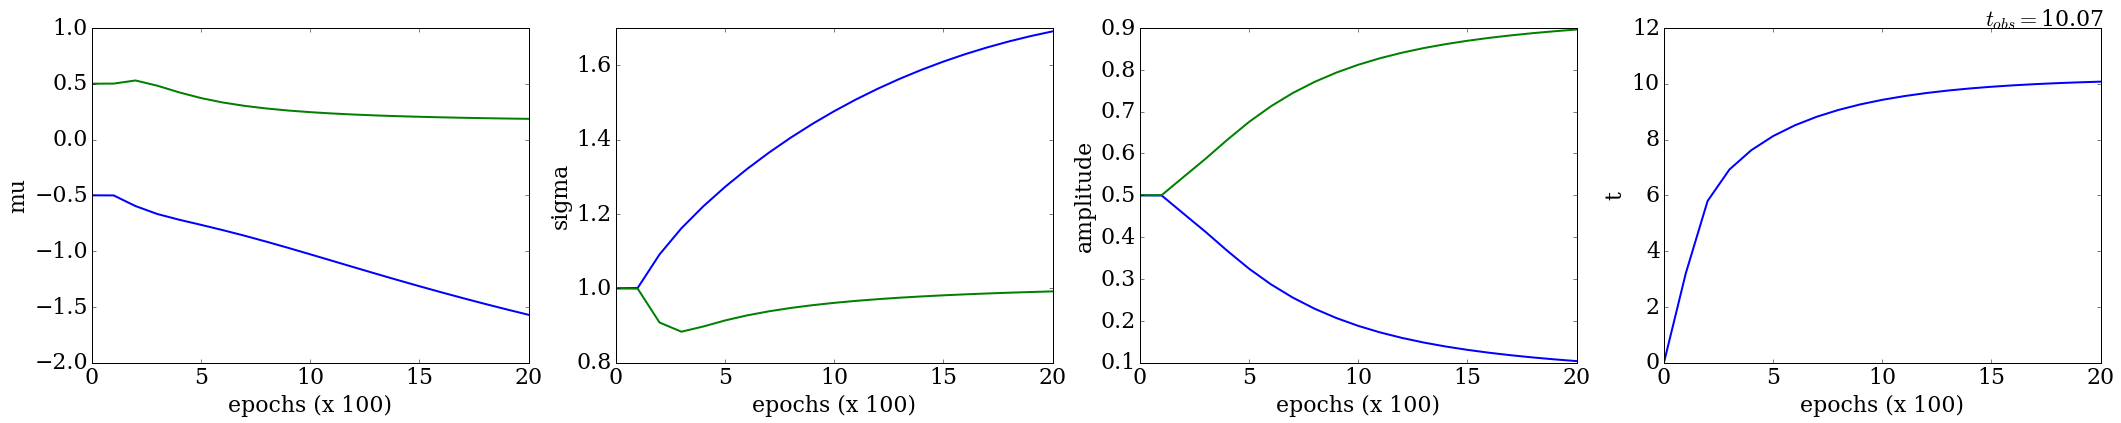

In [8]:
k=2
mu0_list, sigma0_list, amplitude0_list = np.linspace(-0.5, 0.5, k), np.ones(k), np.ones(k)*1./k
model = t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
print(model.summary())
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
model.compile(loss=loss,  optimizer='adam')
####
data = data1
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(1999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

In [9]:
loc2_data1, scale2_data1, amplitude2_data1 = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
print(loc2_data1, scale2_data1, amplitude2_data1)

[-1.57053912  0.18515858] [1.69069624 0.99169195] [-0.57759875  1.57759762]


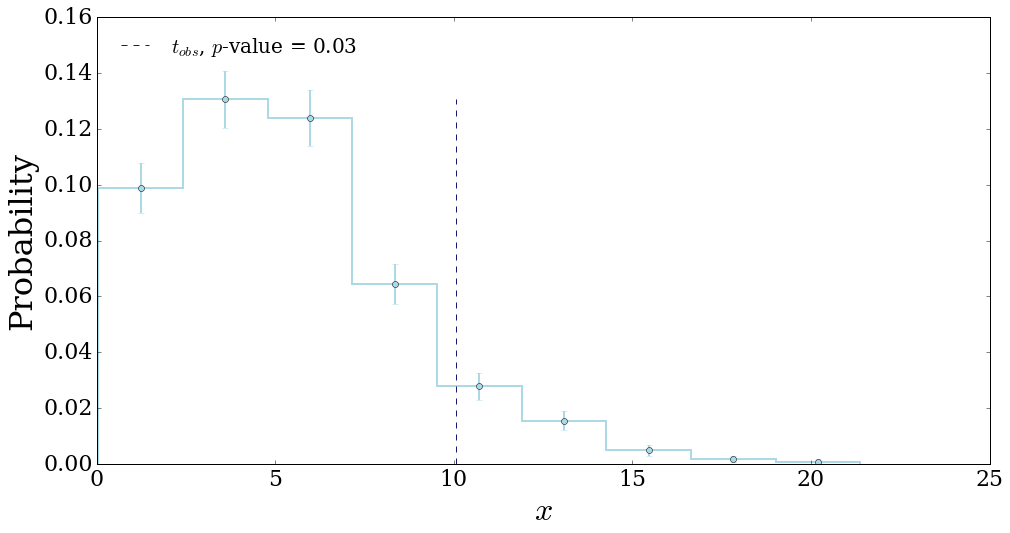

In [413]:
sample1 = np.array(t_ref2)
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 10
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, t_ref), 2))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

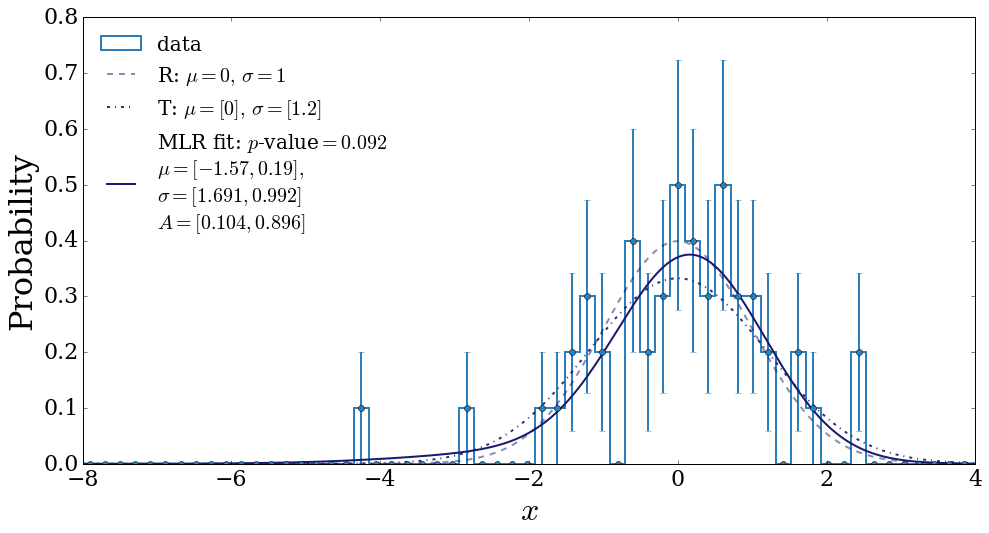

In [414]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 2000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu1]), np.array([std1]), np.array([1.])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=2, alpha=0.9, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if i==4: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, t_ref2), 3)))+'\n'+label)

font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

### alternative 2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 2ms/step


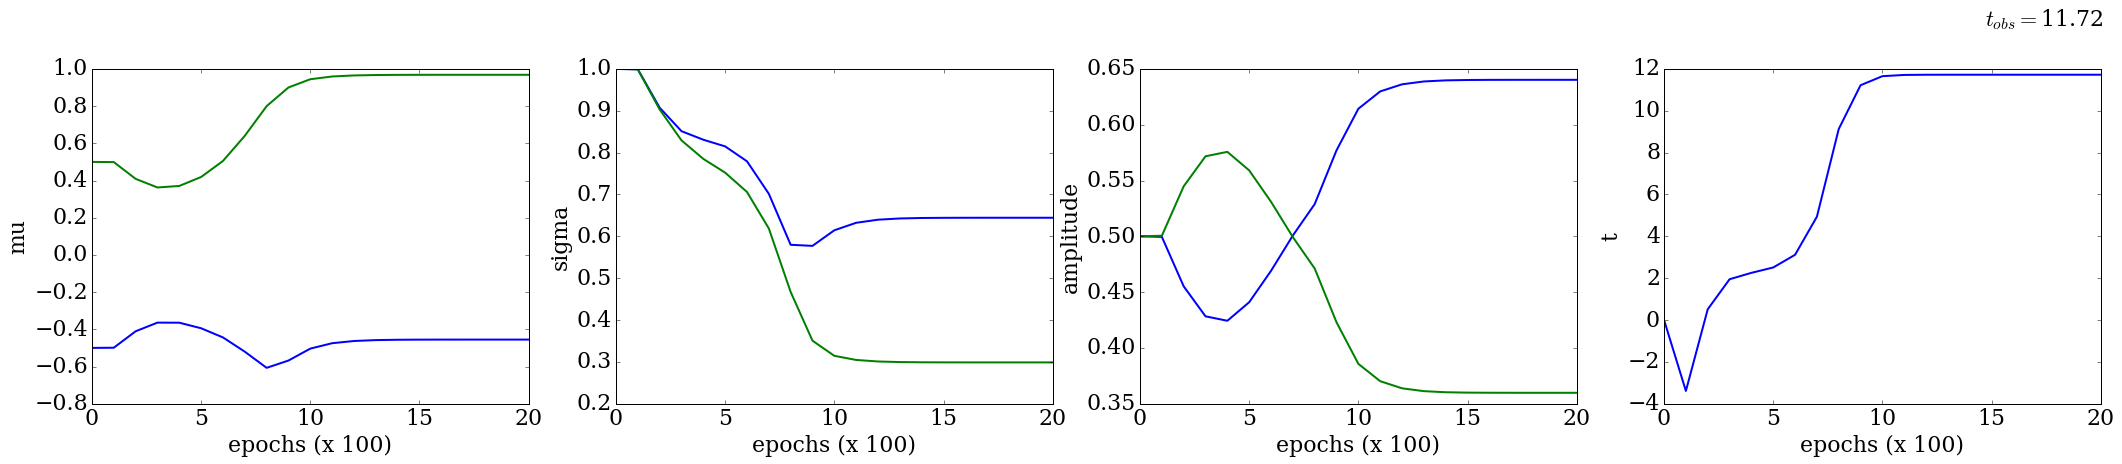

In [10]:
k=2
mu0_list, sigma0_list, amplitude0_list = np.linspace(-0.5, 0.5, k), np.ones(k), np.ones(k)*1./k
model = t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
print(model.summary())
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
model.compile(loss=loss,  optimizer='adam')
####
data = data2
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(1999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

In [11]:
loc2_data2, scale2_data2, amplitude2_data2 = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
print(loc2_data2, scale2_data2, amplitude2_data2)

[-0.45528159  0.96837616] [0.6443404  0.29867998] [0.78816634 0.21183212]


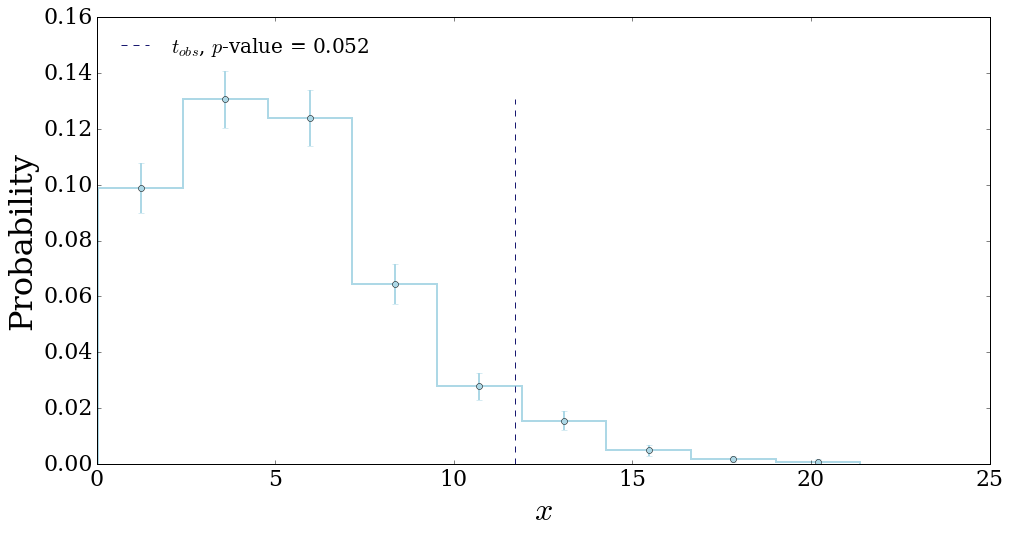

In [357]:
sample1 = np.array(t_ref2)
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 10
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, t_ref2), 3))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

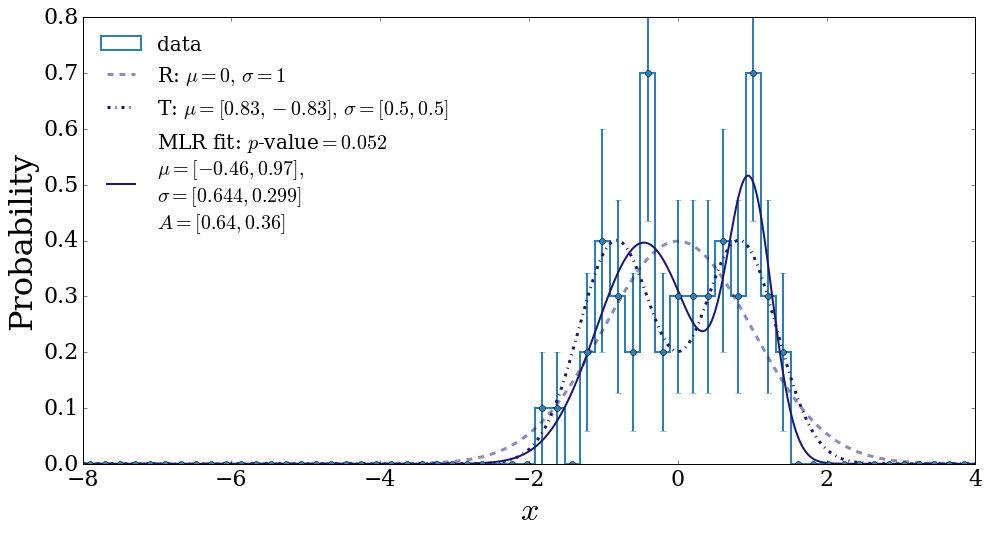

In [359]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 2000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=3, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu2, -mu2]), np.array([std2, std2]), np.array([0.5, 0.5])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=3, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if i==4: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, t_ref2), 3)))+'\n'+label)



font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

# t(k=10)

In [128]:
k=10

In [343]:
t_ref10 = []
for i in range(100):
    mu0_list=np.linspace(-0.5, 0.5, k)
    amplitude0_list=np.ones(k)*1./k
    sigma0_list=np.ones(k)
    model=t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list)
    opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.002)
    model.compile(loss=loss,  optimizer='adam')
    ####
    data = norm.rvs(loc=mu0, scale=std0, size=N)
    for epoch in range(4999):
        model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    pred = model.predict(data.reshape(-1, 1))
    t_ref10.append(-1*loss(np.ones_like(data), pred).numpy())
    print(i, t_ref10[-1])

2/2 [==============================] - 0s 3ms/step
0 33.06333541870117
2/2 [==============================] - 0s 2ms/step
1 46.79698944091797
2/2 [==============================] - 0s 2ms/step
2 35.28933334350586
2/2 [==============================] - 0s 2ms/step
3 19.524585723876953
2/2 [==============================] - 0s 2ms/step
4 32.60480880737305
2/2 [==============================] - 0s 2ms/step
5 20.611722946166992
2/2 [==============================] - 0s 2ms/step
6 34.300540924072266
2/2 [==============================] - 0s 2ms/step
7 25.083112716674805
2/2 [==============================] - 0s 2ms/step
8 30.08062171936035
2/2 [==============================] - 0s 2ms/step
9 34.604393005371094
2/2 [==============================] - 0s 3ms/step
10 15.180726051330566
2/2 [==============================] - 0s 2ms/step
11 15.507316589355469
2/2 [==============================] - 0s 2ms/step
12 33.891761779785156
2/2 [==============================] - 0s 2ms/step
13 41.969772338

KeyboardInterrupt: 

### alternative 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 2ms/step


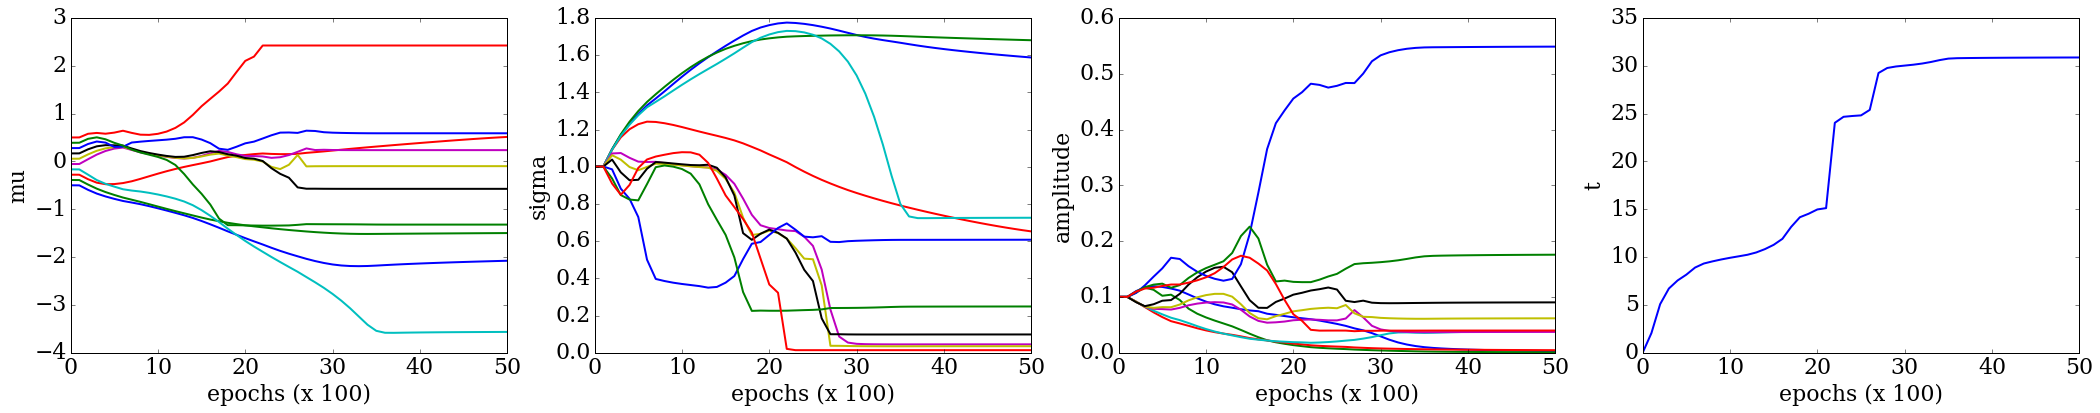

In [408]:
k=10
mu0_list, sigma0_list, amplitude0_list = np.linspace(-0.5, 0.5, k), np.ones(k), np.ones(k)*1./k
model = t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
print(model.summary())
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
model.compile(loss=loss,  optimizer='adam')
####
data = data1
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(4999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
#plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

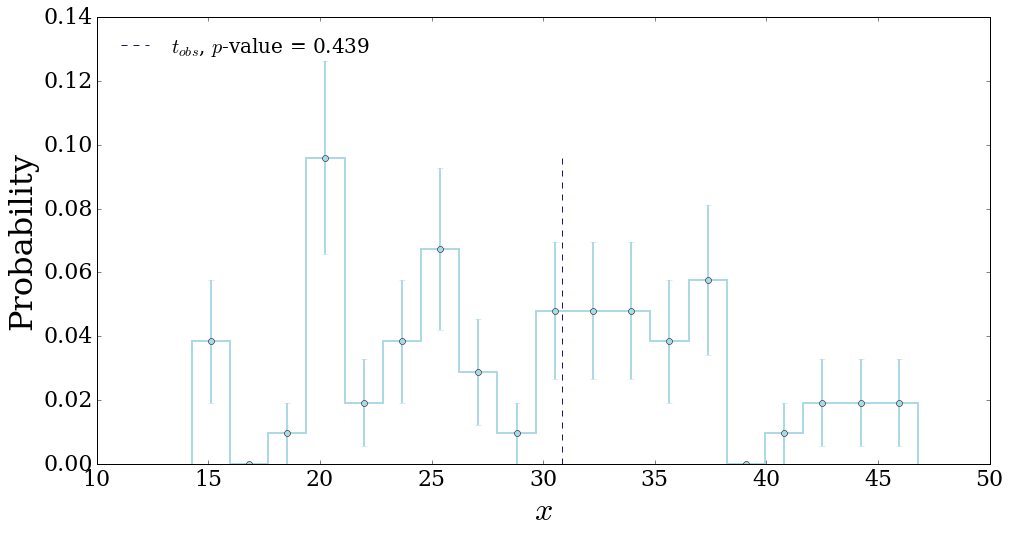

In [409]:
sample1 = np.array(t_ref10)
sample1 = sample1[~np.isnan(sample1)]
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 20
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, t_ref10), 3))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

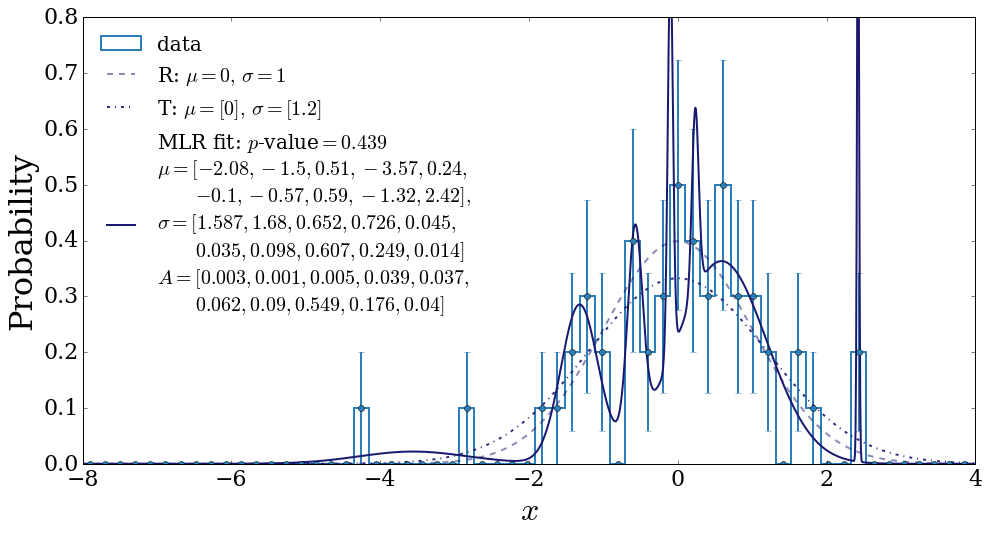

In [411]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 2000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu1]), np.array([std1]), np.array([1.])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=2, alpha=0.9, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if i==4: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, t_ref10), 3)))+'\n'+label)


font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

### alternative 2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 3ms/step


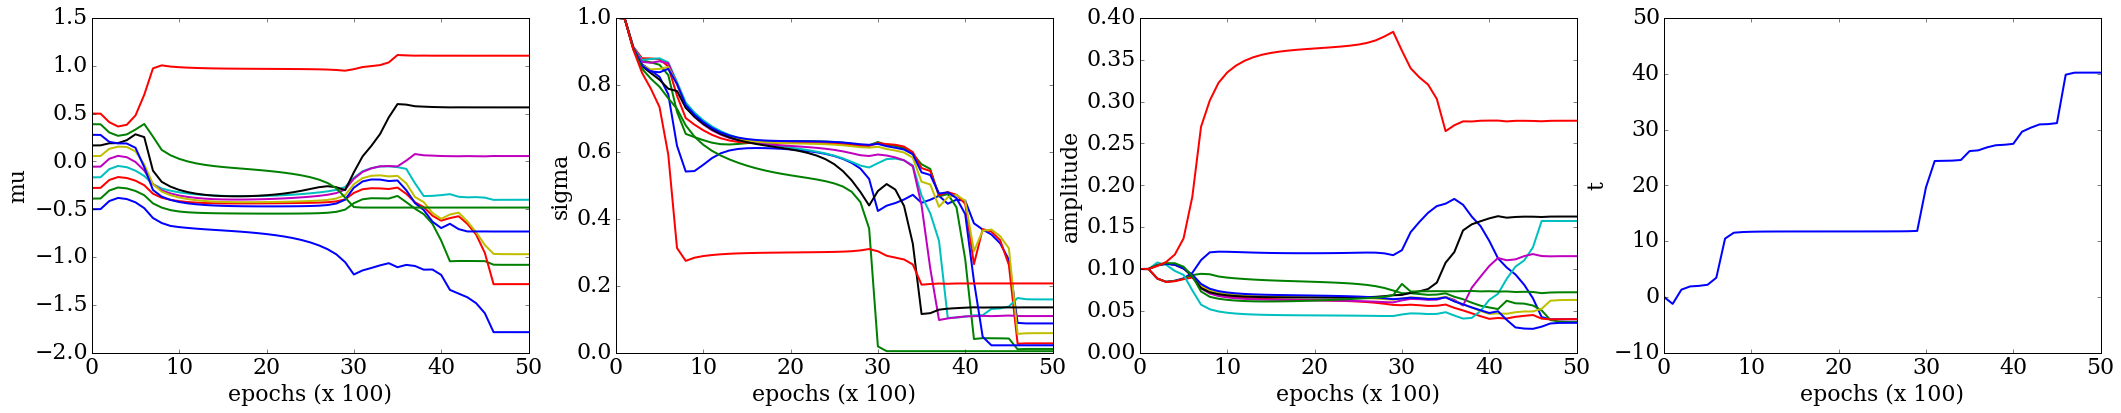

In [361]:
k=10
mu0_list, sigma0_list, amplitude0_list = np.linspace(-0.5, 0.5, k), np.ones(k), np.ones(k)*1./k
model = t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
print(model.summary())
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.002)
model.compile(loss=loss,  optimizer='adam')
####
data = data2
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(4999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
#plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

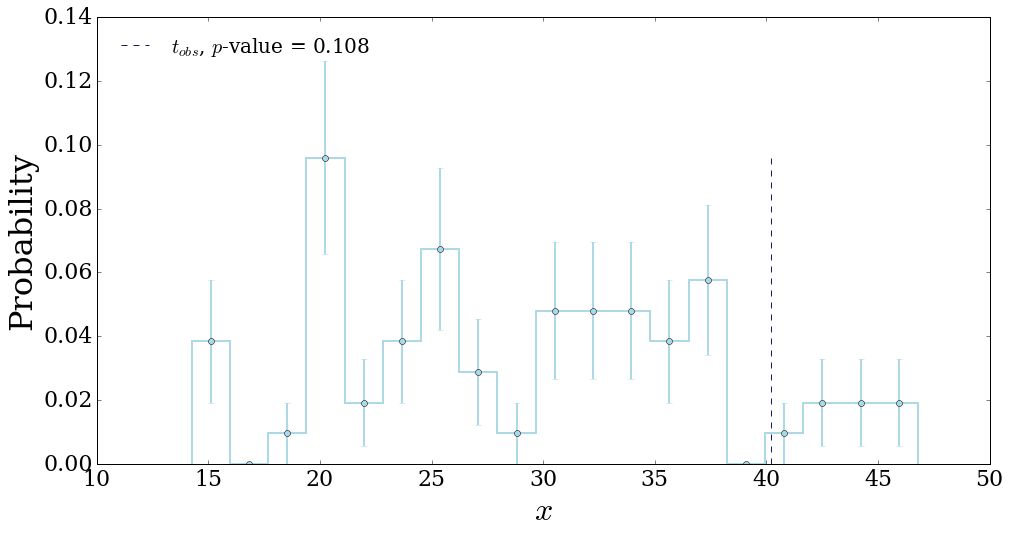

In [362]:
sample1 = np.array(t_ref10)
sample1 = sample1[~np.isnan(sample1)]
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 20
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, t_ref10), 3))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

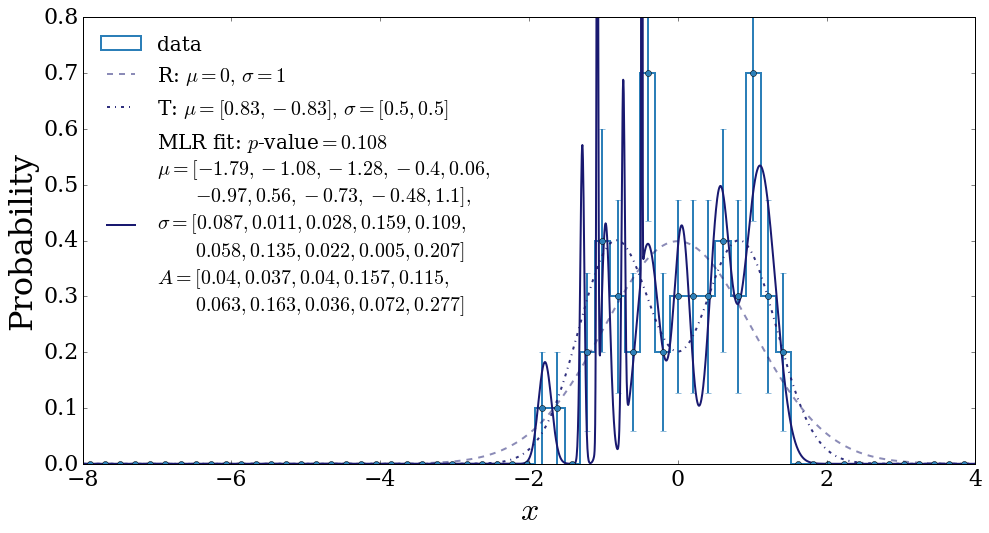

In [363]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu2, -mu2]), np.array([std2, std2]), np.array([0.5, 0.5])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
    
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=2, alpha=0.9, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if i==4: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, t_ref10), 3)))+'\n'+label)


font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

# t(k=15)

In [385]:
k=15
t_ref15 = []
for i in range(100):
    mu0_list=np.linspace(-0.5, 0.5, k)
    amplitude0_list=np.ones(k)*1./k
    sigma0_list=np.ones(k)
    model=t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list)
    opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.002)
    model.compile(loss=loss,  optimizer='adam')
    ####
    data = norm.rvs(loc=mu0, scale=std0, size=N)
    for epoch in range(4999):
        model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    pred = model.predict(data.reshape(-1, 1))
    t_ref15.append(-1*loss(np.ones_like(data), pred).numpy())
    print(i, t_ref15[-1])

2/2 [==============================] - 0s 2ms/step
0 50.438934326171875
2/2 [==============================] - 0s 2ms/step
1 nan
2/2 [==============================] - 0s 2ms/step
2 63.58470916748047
2/2 [==============================] - 0s 3ms/step
3 70.51778411865234
2/2 [==============================] - 0s 2ms/step
4 39.687530517578125
2/2 [==============================] - 0s 2ms/step
5 40.47549057006836
2/2 [==============================] - 0s 2ms/step
6 48.5089225769043
2/2 [==============================] - 0s 2ms/step
7 41.421199798583984
2/2 [==============================] - 0s 2ms/step
8 37.63202667236328
2/2 [==============================] - 0s 2ms/step
9 33.3043098449707
2/2 [==============================] - 0s 2ms/step
10 42.05338668823242
2/2 [==============================] - 0s 2ms/step
11 nan
2/2 [==============================] - 0s 2ms/step
12 62.997989654541016
2/2 [==============================] - 0s 2ms/step
13 35.910125732421875
2/2 [======================

KeyboardInterrupt: 

### alternative 2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 2ms/step


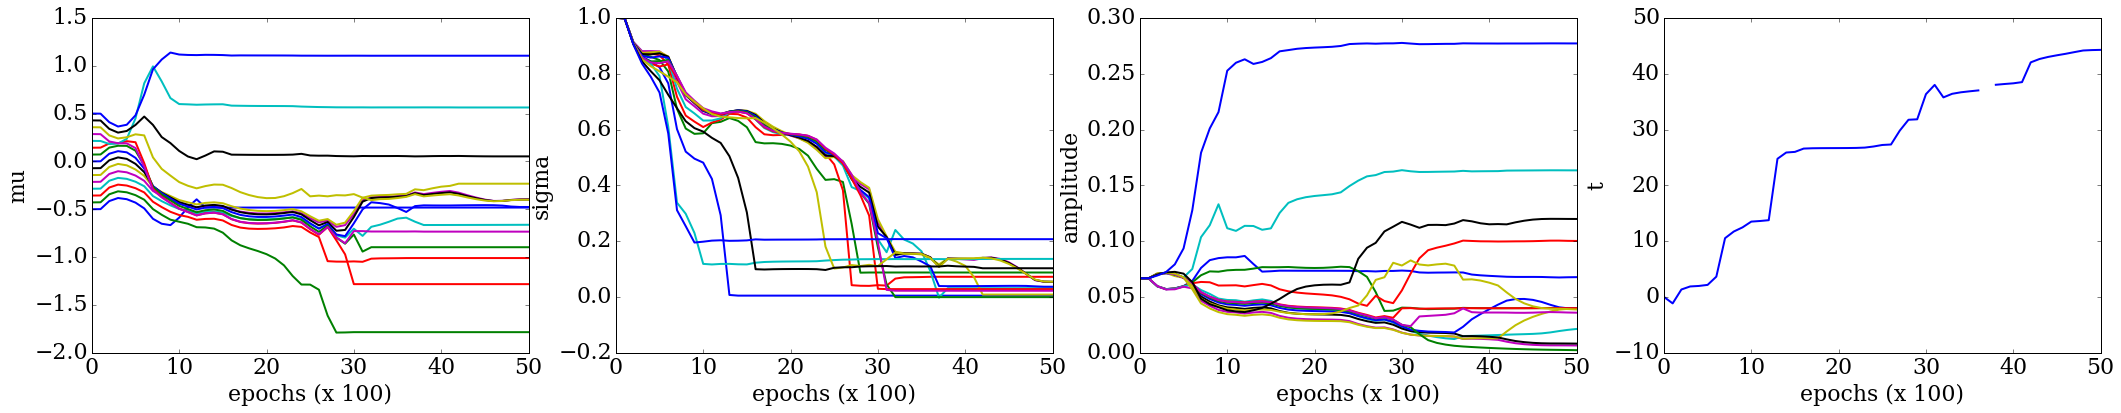

In [12]:
k=15
mu0_list, sigma0_list, amplitude0_list = np.linspace(-0.5, 0.5, k), np.ones(k), np.ones(k)*1./k
model = t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
print(model.summary())
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.003)
model.compile(loss=loss,  optimizer='adam')
####
data = data2
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(4999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
#plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

In [13]:
loc15_data2, scale15_data2, amplitude15_data2 = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
print(loc15_data2, scale15_data2, amplitude15_data2)

[-0.48253378 -1.78515363 -1.01055455 -0.66267329 -0.39572486 -0.23320478
 -0.39861903 -0.47678214 -0.89719123 -1.28316069  0.56363595 -0.73458409
 -0.40109846  0.05238187  1.1047678 ] [ 0.00444998  0.08747938  0.07209443  0.03142656  0.0536896   0.00839282
  0.05414591  0.03653423 -0.00082716  0.02792058  0.1361759   0.02197483
  0.05445515  0.10268804  0.20692317] [ 0.29570794 -0.23083021  0.68698257 -0.86164665 -2.05203104 -0.2446662
 -1.8218298  -0.23786221 -3.09777427 -0.23338675  1.17664206 -0.33988136
 -0.26298732  0.86661434  1.70495522]


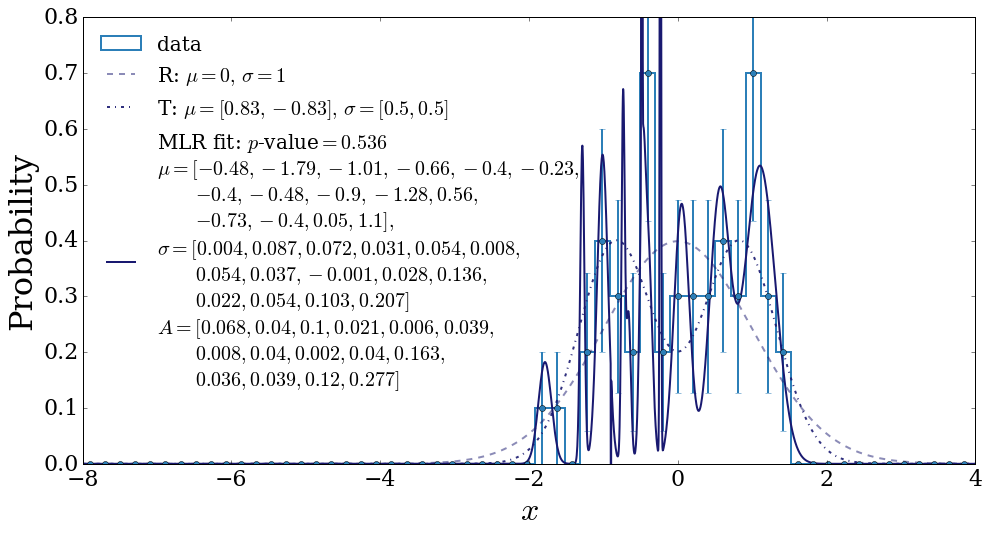

In [400]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu2, -mu2]), np.array([std2, std2]), np.array([0.5, 0.5])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
    
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=2, alpha=0.9, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if not i%5 and i: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, sample1), 3)))+'\n'+label)


font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

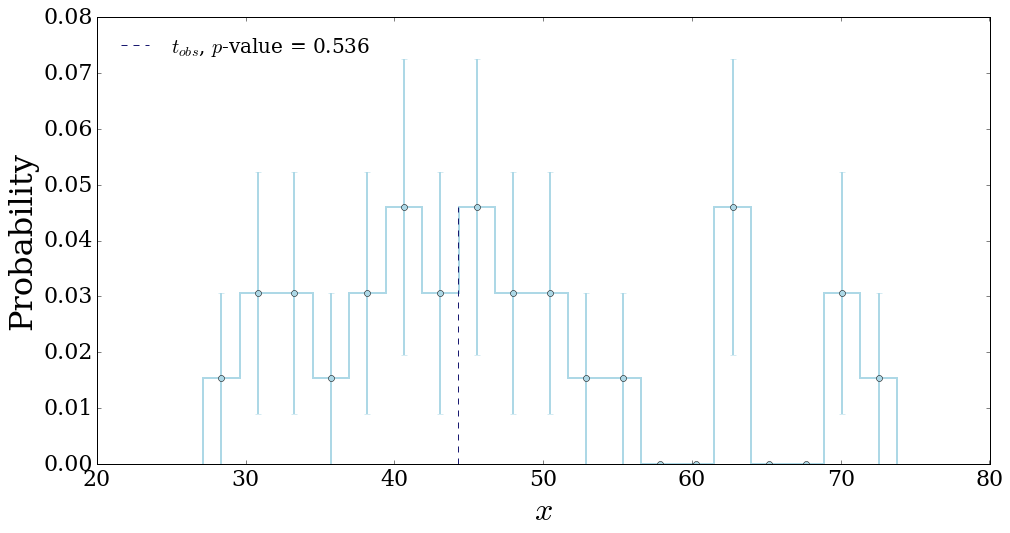

In [392]:
sample1 = np.array(t_ref15)
sample1 = sample1[~np.isnan(sample1)]
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 20
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, sample1), 3))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

### alternative 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 2ms/step


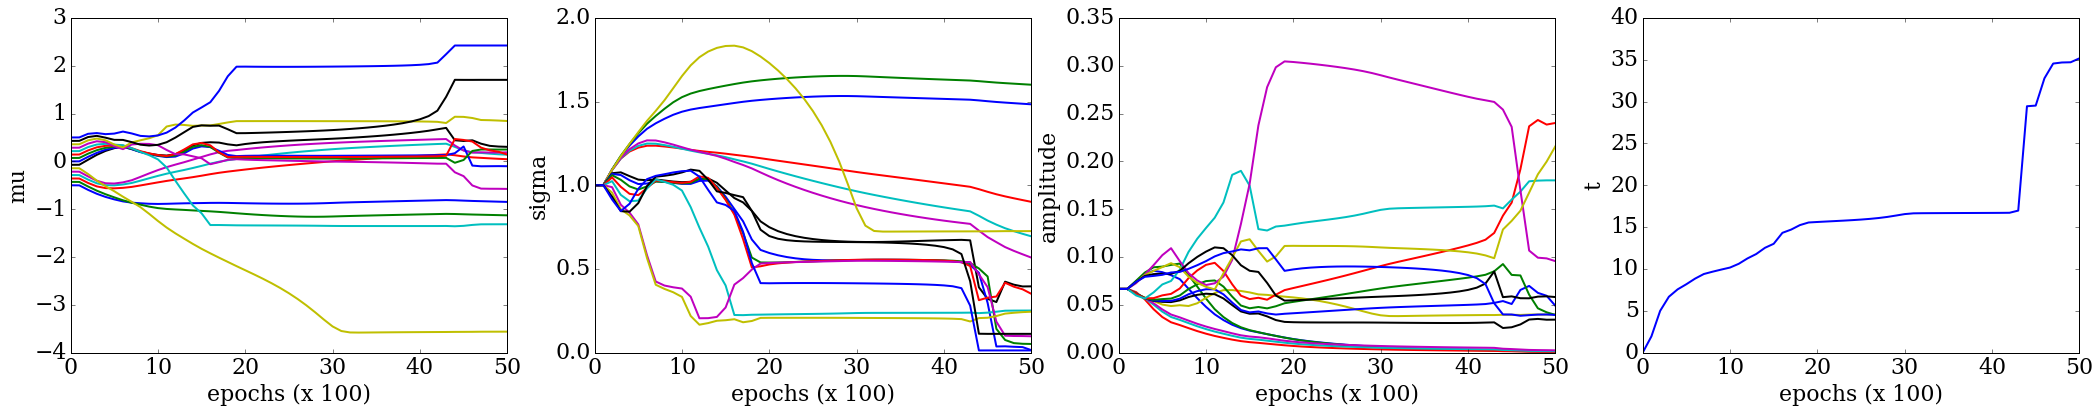

In [14]:
k=15
mu0_list, sigma0_list, amplitude0_list = np.linspace(-0.5, 0.5, k), np.ones(k), np.ones(k)*1./k
model = t_k_gaussian(k=k, input_shape=(None, 1), mu0_list=mu0_list, sigma0_list=sigma0_list, amplitude0_list=amplitude0_list, train_amplitude=True)
print(model.summary())
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.003)
model.compile(loss=loss,  optimizer='adam')
####
data = data1
hist = {}
hist['mu']=np.array(mu0_list).reshape(1, -1)
hist['sigma']=np.array(sigma0_list).reshape(1, -1)
hist['amplitude']=np.array(amplitude0_list).reshape(1, -1)
hist['loss']=np.array([0])
for epoch in range(4999):
    model.train_on_batch(data.reshape(-1, 1), np.ones_like(data))
    if not epoch%100:
        hist['mu']=np.concatenate((hist['mu'], model.mu[0].numpy().reshape(1, -1)), axis=0)
        hist['sigma']=np.concatenate((hist['sigma'], model.sigma[0].numpy().reshape(1, -1)), axis=0)
        hist['amplitude']=np.concatenate((hist['amplitude'], model.amplitude[0].numpy().reshape(1, -1)), axis=0)
        hist['loss']=np.append(hist['loss'], loss(np.ones_like(data), model.predict( data.reshape(-1, 1))).numpy())
fig, ax = plt.subplots(1, 4, figsize=(36, 6))
fig.patch.set_facecolor('white')
plt.subplot(1, 4, 1)
for i in range(k):
    plt.plot(hist['mu'][:, i], lw=2)
plt.ylabel('mu', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 2)
for i in range(k):
    plt.plot(hist['sigma'][:, i], lw=2)
plt.ylabel('sigma', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 3)
for i in range(k):
    plt.plot(np.exp(hist['amplitude'][:, i])/np.sum(np.exp(hist['amplitude']), axis=1), lw=2)
plt.ylabel('amplitude', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")

plt.subplot(1, 4, 4)
plt.plot(-1*hist['loss'], lw=2)
plt.ylabel('t', fontsize=22, fontname="serif")
plt.xlabel('epochs (x 100)', fontsize=22, fontname="serif")
#plt.yscale('log')
t_obs = -1*hist['loss'][-1]
#plt.text(x=0.7*len(hist['loss']), y=1.2*t_obs, s=r'$t_{obs}=$'+str(np.around(t_obs,2)), fontsize=22, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()


In [15]:
loc15_data1, scale15_data1, amplitude15_data1 = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
print(loc15_data1, scale15_data1, amplitude15_data1)

[-0.84723222 -1.12756312  0.04549203  0.13993256  0.18964331 -3.55981398
  0.30413064 -0.10095529  0.24803671  0.14332825 -1.31431758 -0.57537031
  0.84445637  1.70477879  2.42306805] [1.48383987 1.60084713 0.90118873 0.69526023 0.56821895 0.7263568
 0.39640945 0.01533023 0.05223921 0.35178864 0.25194696 0.09819609
 0.24488762 0.11262216 0.0136565 ] [-2.68882775 -2.84845543 -3.0624938  -2.47210431 -2.03356123  0.74079764
  0.59550011  0.94679219  0.7287156   2.53384018  2.24642205  1.61402094
  2.42637992  1.11627507  0.72901255]


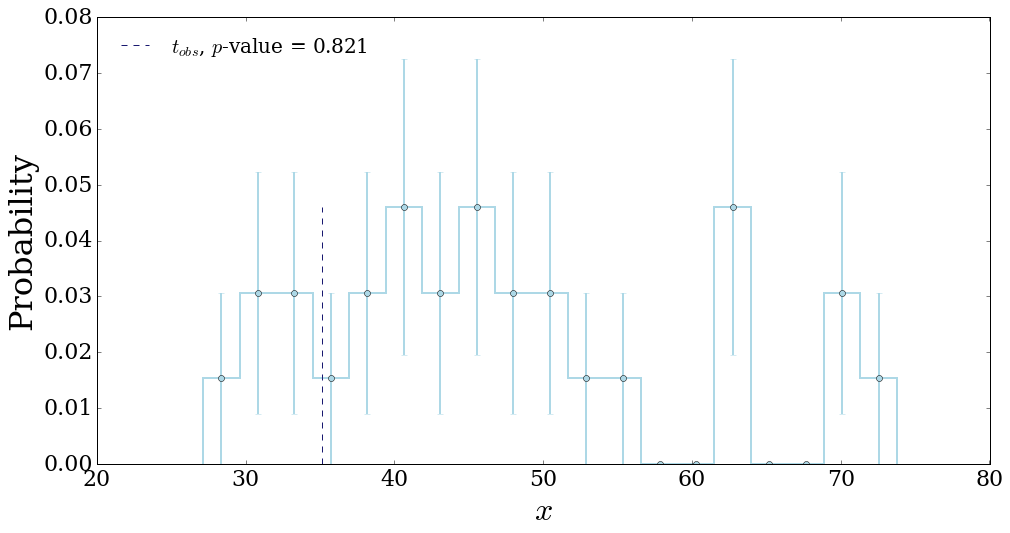

In [402]:
sample1 = np.array(t_ref15)
sample1 = sample1[~np.isnan(sample1)]
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')
xmin, xmax, nbins = np.min(sample1), np.max(sample1), 20
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             histtype='step', color='lightblue', lw=2, bins=bins)
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='lightblue', marker='o', ls='', lw=2)
plt.vlines(x=t_obs, ymin=0, ymax=np.max(h[0]), color='midnightblue', ls='--', 
           label=r'$t_{obs}$, $p$-value = %s'%(str(np.around(p_val_empirical(t_obs, sample1), 3))))
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=2)
#plt.savefig('./1D_CC_asympt_formula.pdf')
plt.show()

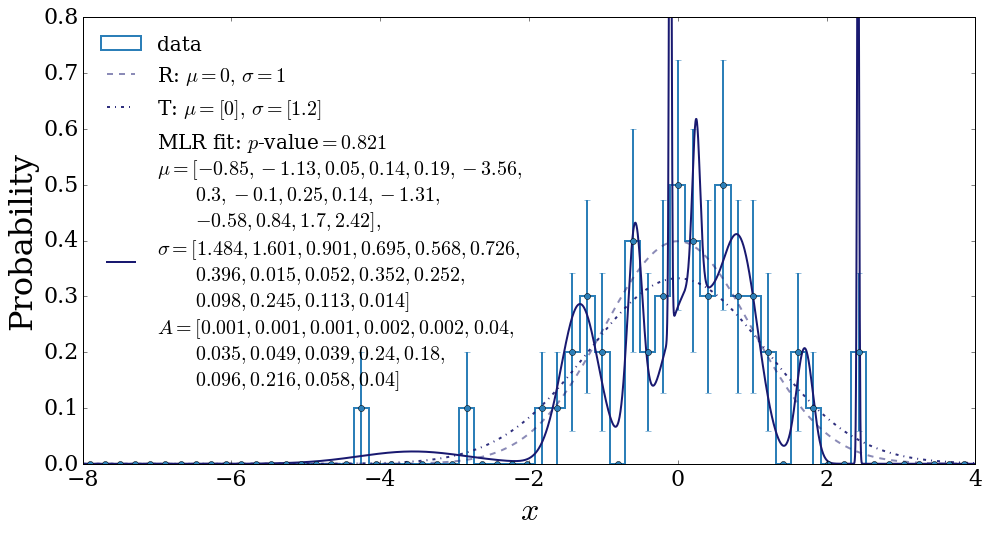

In [404]:
fig  = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
h=plt.hist(data, weights=np.ones(data.shape[0])*1./data.shape[0]/binswidth, bins=bins, histtype='step', color='#2c7fb8', lw=2, label='data')
err = np.sqrt(h[0]/(data.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', lw=2)

x=np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.5, ls='--', label='R: '+label)

loc, scale, amplitude = np.array([mu1]), np.array([std1]), np.array([1.])
str_loc, str_scale = '[', '['
for i in range(len(loc)-1):
    str_loc += str(loc[i])+', '
    str_scale += str(scale[i])+', '
    
str_loc += str(loc[-1])+']'
str_scale += str(scale[-1])+']'
label = r'$\mu= %s,\,\sigma=%s$'%(str_loc, str_scale)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'midnightblue', lw=2, alpha=0.9, ls='-.', label='T: '+label)

loc, scale, amplitude = hist['mu'][-1, :], hist['sigma'][-1, :], hist['amplitude'][-1, :]
str_loc, str_scale, str_ampl = '[', '[', '['
for i in range(len(loc)-1):
    str_loc += str(np.around(loc[i], 2))+', '
    str_scale += str(np.around(scale[i], 3))+', '
    str_ampl += str(np.around(np.exp(amplitude[i])/np.sum(np.exp(amplitude)), 3))+', '
    if not i%5 and i: 
        str_loc +='$\n      $'
        str_scale +='$\n      $'
        str_ampl +='$\n      $'
str_loc += str(np.around(loc[-1],2))+']'
str_scale += str(np.around(scale[-1],3))+']'
str_ampl += str(np.around(np.exp(amplitude[-1])/np.sum(np.exp(amplitude)), 3))+']'
label = r'$\mu= %s,$'%(str_loc)+'\n'+r'$\sigma=%s$'%(str_scale)+'\n'+r'$A=%s$'%(str_ampl)
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude), color='midnightblue', lw=2, label=r'MLR fit: $p$-value$=%s$'%(str(np.around(p_val_empirical(t_obs, sample1), 3)))+'\n'+label)


font = font_manager.FontProperties(family='serif', size=20)
plt.legend(prop=font, frameon=False, loc='upper left', ncol=1)
plt.ylim(0, 0.8)
plt.xlim(-8, 4)
plt.xlabel(r'$x$', fontsize=32, fontname="serif")
plt.ylabel('Probability', fontsize=32, fontname="serif")
plt.xticks(fontsize=22, fontname="serif")
plt.yticks(fontsize=22, fontname="serif")
plt.show()

# summary plot

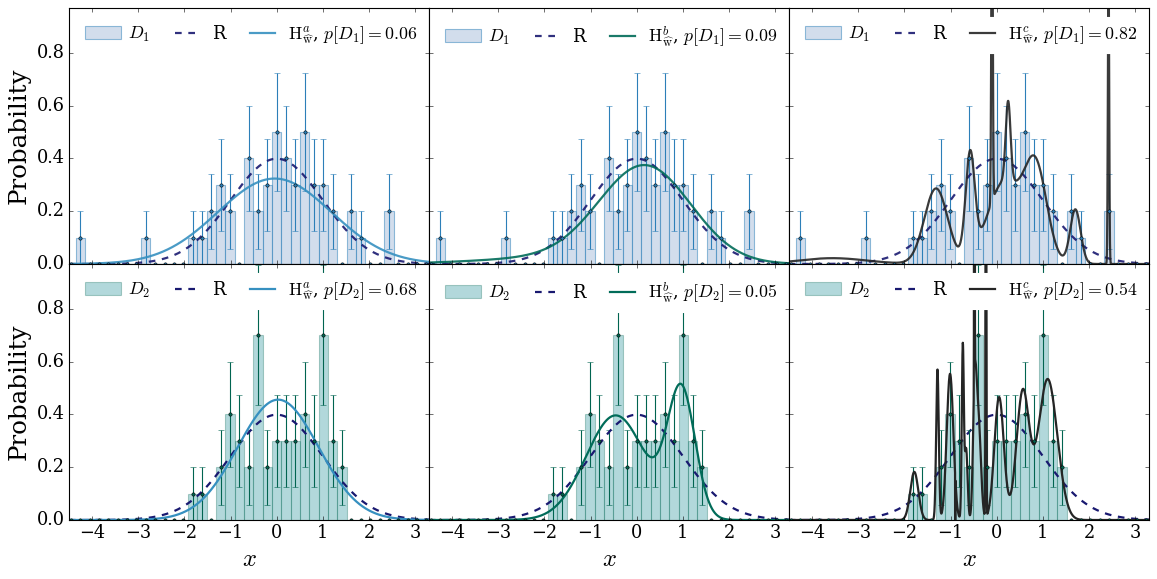

In [17]:
sample1, sample2 = data1, data2
xmin, xmax, nbins = -8, 8, 80
binswidth = (xmax-xmin)*1./nbins
bins = np.linspace(xmin, xmax, nbins)
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
fig = plt.figure(figsize=(15, 8.))                                                                                                                                            
fig.patch.set_facecolor('white')

ax= fig.add_axes([0.1-0.03, 0.5, 0.3, 0.4])
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             color='#a6bddb', alpha=0.5,edgecolor='#2c7fb8', lw=1, bins=bins, label=r'$D_1$')
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', ms=3, lw=1)

x = np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.9, ls='--', label='R')
loc, scale, amplitude = loc1_data1, scale1_data1, amplitude1_data1
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'#3690c0', lw=2, alpha=0.9, ls='-', label=r'${\rm H}^a_{\rm\widehat{w}}$, $p[D_1]=0.06$', zorder=2)

font = font_manager.FontProperties(family='serif', size=16)
plt.legend(prop=font, frameon=True, loc='upper left', ncol=3, handletextpad=0.4, columnspacing=1.1, edgecolor='white')
plt.yticks(fontsize=16, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
ax.tick_params(axis='x', which='both', labelbottom=False)
plt.ylabel('Probability', fontsize=22, fontname="serif")
plt.ylim(0, 0.97)
plt.xlim(-4.5, 3.3)

ax= fig.add_axes([0.4-0.03, 0.5, 0.3, 0.4])
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             color='#a6bddb', alpha=0.5, edgecolor='#2c7fb8', lw=1, bins=bins, label=r'$D_1$')
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', ms=3, lw=1)

x = np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.9, ls='--', label='R')

loc, scale, amplitude = loc2_data1, scale2_data1, amplitude2_data1
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'#016c59', lw=2, alpha=0.9, ls='-', label=r'${\rm H}^b_{\rm\widehat{w}}$, $p[D_1]=0.09$', zorder=2)
font = font_manager.FontProperties(family='serif', size=16)
plt.legend(prop=font, frameon=True, loc='upper left', ncol=3, handletextpad=0.4, columnspacing=1.1, edgecolor='white')
plt.yticks(fontsize=16, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
ax.tick_params(axis='y', which='both', labelleft=False)
ax.tick_params(axis='x', which='both', labelbottom=False)
plt.ylim(0, 0.97)
plt.xlim(-4.5, 3.3)

ax= fig.add_axes([0.7-0.03, 0.5, 0.3, 0.4])
h = plt.hist(sample1, weights=np.ones_like(sample1)*1./(sample1.shape[0]*binswidth), 
             color='#a6bddb', alpha=0.5,#histtype='step', 
             edgecolor='#2c7fb8', lw=1, bins=bins, label=r'$D_1$')
err = np.sqrt(h[0]/(sample1.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='', ms=3, lw=1)

x = np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, alpha=0.9, ls='--', label='R')
loc, scale, amplitude = loc15_data1, scale15_data1, amplitude15_data1
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'#252525', lw=2, alpha=0.9, ls='-', label=r'${\rm H}^c_{\rm\widehat{w}}$, $p[D_1]=0.82$')

font = font_manager.FontProperties(family='serif', size=16)
plt.legend(prop=font, frameon=True, loc='upper left', ncol=3, handletextpad=0.4, columnspacing=1.1, edgecolor='white')
plt.yticks(fontsize=16, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
ax.tick_params(axis='y', which='both', labelleft=False)
ax.tick_params(axis='x', which='both', labelbottom=False)
plt.xlabel(r'$x$', fontsize=22, fontname="serif")
plt.ylim(0, 0.97)
plt.xlim(-4.5, 3.3)

######################################
ax= fig.add_axes([0.1-0.03, 0.1, 0.3, 0.4])
h = plt.hist(sample2, weights=np.ones_like(sample2)*1./(sample2.shape[0]*binswidth), 
             color='#02818a', alpha=0.3, edgecolor='#016450', lw=1, bins=bins, label=r'$D_2$')
err = np.sqrt(h[0]/(sample2.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#016450', marker='o', ls='', ms=3, lw=1)

x = np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, ls='--', label='R')
loc, scale, amplitude = loc1_data2, scale1_data2, amplitude1_data2
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'#3690c0', lw=2, ls='-', label=r'${\rm H}^a_{\rm\widehat{w}}$, $p[D_2]=0.68$', zorder=2)
font = font_manager.FontProperties(family='serif', size=16)
plt.legend(prop=font, frameon=True, loc='upper left', ncol=3, handletextpad=0.4, columnspacing=1.1, edgecolor='white')
plt.yticks(fontsize=16, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
plt.xlabel(r'$x$', fontsize=22, fontname="serif")
plt.ylabel('Probability', fontsize=22, fontname="serif")
plt.ylim(0, 0.97)
plt.xlim(-4.5, 3.3)

ax= fig.add_axes([0.4-0.03, 0.1, 0.3, 0.4])
h = plt.hist(sample2, weights=np.ones_like(sample2)*1./(sample2.shape[0]*binswidth), 
             color='#02818a', alpha=0.3, edgecolor='#016450', lw=1, bins=bins, label=r'$D_2$')
err = np.sqrt(h[0]/(sample2.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#016450', marker='o', ls='', ms=3, lw=1)

x = np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, ls='--', label='R')
loc, scale, amplitude = loc2_data2, scale2_data2, amplitude2_data2
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'#016c59', lw=2, ls='-', label=r'${\rm H}^b_{\rm\widehat{w}}$, $p[D_2]=0.05$', zorder=2)

font = font_manager.FontProperties(family='serif', size=16)
plt.legend(prop=font, frameon=True, loc='upper left', ncol=3, handletextpad=0.4, columnspacing=1.1, edgecolor='white')
plt.yticks(fontsize=16, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
ax.tick_params(axis='y', which='both', labelleft=False)
plt.xlabel(r'$x$', fontsize=22, fontname="serif")
plt.ylim(0, 0.97)
plt.xlim(-4.5, 3.3)

ax= fig.add_axes([0.7-0.03, 0.1, 0.3, 0.4])
h = plt.hist(sample2, weights=np.ones_like(sample2)*1./(sample2.shape[0]*binswidth), 
             color='#02818a', alpha=0.3, edgecolor='#016450', lw=1, bins=bins, label=r'$D_2$')
err = np.sqrt(h[0]/(sample2.shape[0]*binswidth))
x   = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(x, h[0], yerr = err, color='#016450', marker='o', ls='', ms=3, lw=1)

x = np.linspace(-8, 8, 4000)
loc, scale = mu0, std0
label = r'$\mu= %i,\,\sigma=%i$'%(loc, scale)
plt.plot(x, norm.pdf(x, loc=loc, scale=scale),'midnightblue', lw=2, ls='--', label='R', zorder=1)
loc, scale, amplitude = loc15_data2, scale15_data2, amplitude15_data2
plt.plot(x, prob_k_gaussian(x, loc, scale, amplitude),'#252525', lw=2, ls='-', label=r'${\rm H}^c_{\rm\widehat{w}}$, $p[D_2]=0.54$', zorder=2)

font = font_manager.FontProperties(family='serif', size=16)
plt.legend(prop=font, frameon=True, loc='upper left', ncol=3, handletextpad=0.4, columnspacing=1.1, edgecolor='white')
plt.yticks(fontsize=16, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
ax.tick_params(axis='y', which='both', labelleft=False)
plt.xlabel(r'$x$', fontsize=22, fontname="serif")
plt.ylim(0, 0.97)
plt.xlim(-4.5, 3.3)
plt.savefig('./illustrative_plot.pdf')
plt.show()